# Multiple linear regression

Analysis of the data from J. Durbin and G.S. Watson (1951). "Testing for Serial Correlation in
Least Squares Regression. II," Biometrika, Vol. 38 #1/2 pp. 159-177, obtained from http://users.stat.ufl.edu/~winner/datasets.html.

The dataset contains 5 colums: Year, log spirit consumption per head ($y$), log income per head ($x_1$), log realtive price of spirits ($x_2$), price/income ($x_2/x_1$).

### The model

The model used is the following:

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon $$

where the $\beta_i$ are the model parameters, and $\epsilon$ is a Gaussian noise component of the form $\mathcal{N}(0,\sigma_\epsilon)$, or what is the same, $y$ is a random variable $\mathcal{N}(\beta_0 + \beta_1 x_1 + \beta_2 x_2,\sigma_\epsilon)$. Thus, the model has 4 parameters, the 3 $\beta_i$ and the nuisance parameter $\sigma_\epsilon$.

### The prior

We will use uniform "improper" priors on $\beta_i$ and a logarithmic improper prior $\sigma_\epsilon$.

## PyStan code

In [1]:
import pystan
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [2]:
names = ["year","consumption","income","price"]
spirits_data = pd.read_csv("spirits.dat", header=None, sep="\s+", names=names, usecols=[0,1,2,3])
years = spirits_data.year
spirits_data.drop("year",axis=1,inplace=True)
y, x = spirits_data.consumption.values, spirits_data[["income", "price"]].values

In [3]:
multiple_lr_code = """
data {
  int<lower=0> N;
  matrix[N,2] x;
  vector[N] y;
}

parameters {
  real<lower=-20,upper=20> b0;
  real<lower=-20,upper=20> b1;
  real<lower=-20,upper=20> b2; 
  real log_sigma_e;
}

transformed parameters {
  real sigma_e;
  sigma_e = exp(log_sigma_e);
}

model {
  for (i in 1:N) {
    y[i] ~ normal(b0 + b1 * x[i,1] + b2 * x[i,2], sigma_e);
  }
  
}

generated quantities {
    vector[N] log_lik;
    vector[N] y_hat;
    for (i in 1:N) {
        log_lik[i] = normal_lpdf(y[i] | b0 + b1 * x[i,1] + b2 * x[i,2], sigma_e);
        y_hat[i] = normal_rng(b0 + b1 * x[i,1] + b2 * x[i,2], sigma_e);
    }
}
"""

In [4]:
multiple_lr_dat = {'N': len(y),
               'y': y,
               'x': x}

sm = pystan.StanModel(model_code=multiple_lr_code)
fit = sm.sampling(data=multiple_lr_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_642e025bceae50418804f2ef495dabba NOW.


In [5]:
dims = {"y":["year"], "x":["year","predictor"], "log_likelihood": ["year"], "y_hat": ["year"]}
coords = {"year":years,"predictor":["income","price"]}
idata = az.from_pystan(
    posterior=fit,
    posterior_predictive='y_hat',
    observed_data=['y', 'x'],
    log_likelihood='log_lik',
    coords=coords,
    dims=dims
)

In [6]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> observed_data

<xarray.Dataset>
Dimensions:      ()
Data variables:
    b0           float64 690.6
    b1           float64 629.1
    b2           float64 897.5
    log_sigma_e  float64 857.1
    sigma_e      float64 857.1


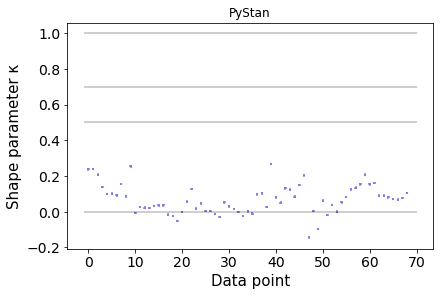

In [7]:
print(az.ess(idata))
loo_df = az.loo(idata,pointwise=True)
ax = az.plot_khat(loo_df.pareto_k)
ax.set_title("PyStan");

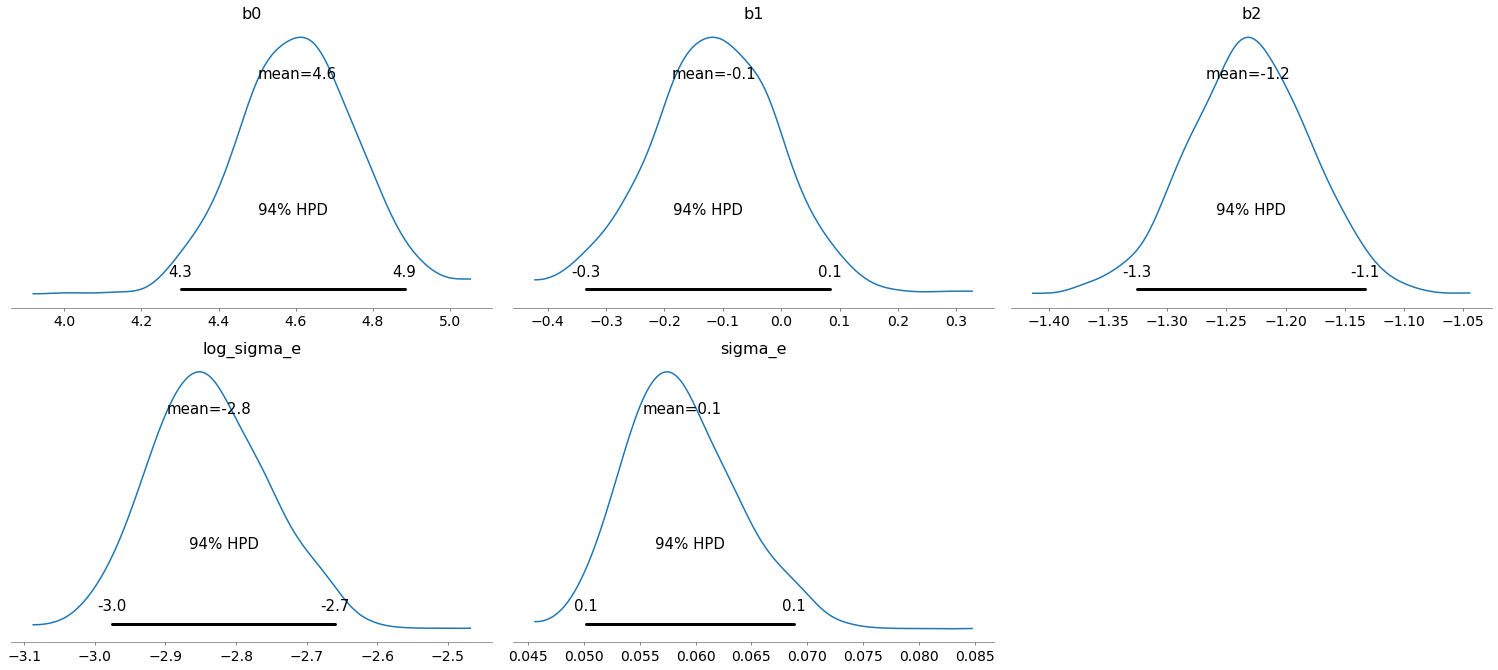

In [8]:
az.plot_posterior(idata);

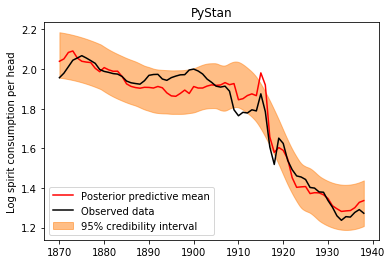

In [9]:
x_plot = idata.observed_data.y.coords["year"].values
y_hats = idata.posterior_predictive.y_hat.values.reshape((-1,69))
az.plot_hpd(x_plot, y_hats, fill_kwargs={"label": "95% credibility interval"});
plt.plot(x_plot, idata.posterior_predictive.y_hat.mean(dim=["draw", "chain"]),color='red',label="Posterior predictive mean")
plt.plot(x_plot, idata.observed_data.y.values,color='k',label="Observed data")
plt.legend(); plt.ylabel("Log spirit consumption per head");
plt.title("PyStan");